<a href="https://colab.research.google.com/github/yujiimt/chainer_tutorial/blob/master/chainer_tutorial/chainer_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


x, t = load_iris(return_X_y=True)
x = x.astype('float32')
t = t.astype('int32')

In [0]:
from chainer.datasets import TupleDataset

dataset = TupleDataset(x, t)

In [21]:
dataset[0]

(array([5.1, 3.5, 1.4, 0.2], dtype=float32), 0)

In [0]:
from chainer.datasets import split_dataset_random

"""
datasetのデータの70%をtrain_valにそれ以外をtestに。
その70%をさらに分ける

"""

train_val, test = split_dataset_random(dataset, int(len(dataset) * 0.7), seed= 0)
train,valid = split_dataset_random(train_val,int(len(train_val) * 0.7), seed = 0)

In [23]:
from chainer.iterators import SerialIterator

train_iter = SerialIterator(train, batch_size=4, repeat=True, shuffle=True)

minibatch = train_iter.next()

minibatch

[(array([7.2, 3.6, 6.1, 2.5], dtype=float32), 2),
 (array([4.4, 3.2, 1.3, 0.2], dtype=float32), 0),
 (array([5.7, 4.4, 1.5, 0.4], dtype=float32), 0),
 (array([5.8, 2.7, 5.1, 1.9], dtype=float32), 2)]

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F


class Net(chainer.Chain):
  
  def __init__(self, n_inputs=4, n_hidden=3, n_outputs=3):
         super().__init__()
         with self.init_scope():
          self.l1 = L.Linear(n_inputs,n_hidden)
          self.l2 = L.Linear(n_hidden,n_hidden)
          self.l3 = L.Linear(n_hidden,n_outputs)
          
  def forward(self,x):
         h = F.relu(self.l1(x))
         h = F.relu(self.l2(h))
         h = self.l3(h)
          
         return h
        
net = Net()

In [0]:
net = Net(n_hidden= 100)

In [0]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.SGD(lr= 0.001)
optimizer.setup(net)

for param in net.params():
      if param.name != 'b':
          param.update_rule.add_hook(WeightDecay(0.0001))

In [0]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.MomentumSGD(lr=0.001,momentum=0.9)
optimizer.setup(net)

for param in net.params():
  if param.name != 'b':
      param.update_rule.add_hook(WeightDecay(0.0001))

In [28]:
gpu_id = 0
n_batch = 64
n_epochs = 50

net.to_gpu(gpu_id)

results_train, results_valid = {}, {}
results_train['loss'], results_train['accuracy'] = [], []
results_valid['loss'], results_valid['accuracy'] = [], []

train_iter.reset() 

count = 1

for epoch in range(n_epochs):
      while True:
              # ミニバッチの取得
            train_batch = train_iter.next() 
            #データをGPUに転送するために、concat_examplesにgpu_idを渡す
            x_train, t_train = chainer.dataset.concat_examples(train_batch,gpu_id)  
            
            #予測値と目的関数の計算
            y_train = net(x_train)
            loss_train = F.softmax_cross_entropy(y_train, t_train)
            acc_train = F.accuracy(y_train, t_train)
            
            
            #勾配の初期化と計算
            net.cleargrads()
            loss_train.backward()
            
            optimizer.update()
            
            count += 1
            
            
            if train_iter.is_new_epoch:
                
                
                with chainer.using_config('train',False), chainer.using_config('enable_backprop',False):
                      x_valid, t_valid = chainer.dataset.concat_examples(valid, gpu_id)
                      y_valid = net(x_valid)
                      loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
                      acc_valid = F.accuracy(y_valid, t_valid)
                      
                loss_train.to_cpu()
                loss_valid.to_cpu()
                acc_train.to_cpu()
                acc_valid.to_cpu()
                
                print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'
                  'acc (train): {:.4f}, acc (valid): {:.4f}'.format(
                epoch, count, loss_train.array.mean(), loss_valid.array.mean(),
                  acc_train.array.mean(), acc_valid.array.mean()))
                
                
                results_train['loss'].append(loss_train.array)
                results_train['accuracy'].append(acc_train.array)
                results_valid['loss'].append(loss_valid.array)
                results_valid['accuracy'].append(acc_valid.array)
                
                
                break

epoch: 0, iteration: 20, loss (train): 0.9107, loss (valid): 0.9845acc (train): 0.7500, acc (valid): 0.6562
epoch: 1, iteration: 38, loss (train): 0.7925, loss (valid): 0.5497acc (train): 0.5000, acc (valid): 0.7188
epoch: 2, iteration: 56, loss (train): 0.4996, loss (valid): 0.4395acc (train): 0.7500, acc (valid): 0.7188
epoch: 3, iteration: 74, loss (train): 0.3002, loss (valid): 0.3946acc (train): 1.0000, acc (valid): 0.7812
epoch: 4, iteration: 93, loss (train): 0.2562, loss (valid): 0.3593acc (train): 1.0000, acc (valid): 0.8125
epoch: 5, iteration: 111, loss (train): 0.2444, loss (valid): 0.2660acc (train): 1.0000, acc (valid): 0.9688
epoch: 6, iteration: 129, loss (train): 0.4793, loss (valid): 0.2492acc (train): 0.7500, acc (valid): 0.9375
epoch: 7, iteration: 147, loss (train): 0.3467, loss (valid): 0.3064acc (train): 1.0000, acc (valid): 0.8438
epoch: 8, iteration: 166, loss (train): 0.1248, loss (valid): 0.2873acc (train): 1.0000, acc (valid): 0.8438
epoch: 9, iteration: 184

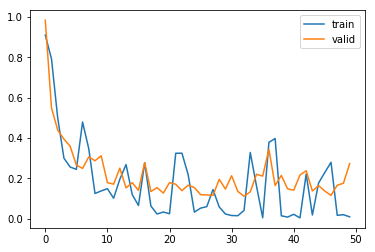

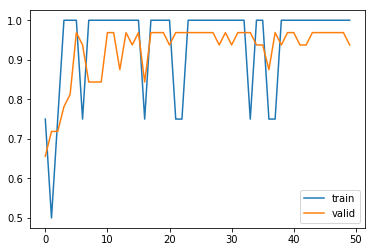

In [29]:
import matplotlib.pyplot as plt


plt.plot(results_train['loss'],label = 'train')
plt.plot(results_valid['loss'],label = 'valid')
plt.legend()
plt.show()

plt.plot(results_train['accuracy'],label = 'train')
plt.plot(results_valid['accuracy'],label = 'valid')
plt.legend()
plt.show()

In [30]:
x_test, t_test = chainer.dataset.concat_examples(test, device=gpu_id)
with chainer.using_config('train',False), chainer.using_config('enable_backprop',False):
       y_test = net(x_test)
       loss_test = F.softmax_cross_entropy(y_test, t_test)
       acc_test = F.accuracy(y_test, t_test)
       
print('test loss: {:.4f}'.format(loss_test.array.get()))
print('test accuracy: {:.4f}'.format(acc_test.array.get()))      

test loss: 0.1961
test accuracy: 0.9111


In [0]:
from chainer.serializers import save_npz

net.to_cpu()
save_npz('net.npz', net)

In [33]:
import numpy as np

params = np.load('net.npz')


for key, param in params.items():
      print(key, ':\t',param.shape)

l3/W :	 (3, 100)
l3/b :	 (3,)
l2/W :	 (100, 100)
l2/b :	 (100,)
l1/W :	 (100, 4)
l1/b :	 (100,)
